# [1.2.5 Zjawisko przeuczenia + regularyzacja](http://pages.mini.pw.edu.pl/~karwowskij/mioad/lab-sieci.html#org7777810)

Zaimplementować mechanizm regularyzacji wag w sieci oraz mechanizm zatrzymywania uczenia przy wzroście błędu na zbiorze walidacyjnym.

Przeprowadzić eksperymenty na zbiorach i porównać skuteczność na zbiorze testowym dla różnych wariantów przeciwdziałania przeuczeniu sieci:

* multimodal-sparse,
* rings5-sparse,
* rings3-balance,
* xor3-balance.

In [201]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
import copy

## Model

In [462]:

class MLP:

    def __init__(self, layers, weights, biases,
                 activation = 'sigmoid',
                 output_function='softmax',
                 visualize_weights=False,
                 max_class = None,
                 regularization_lambda = 0, 
                 seed = 123, 
                 validation_set = None, 
                 early_stop = None):
        
        self.layers = copy.deepcopy(layers)
        self.weights = copy.deepcopy(weights)
        self.biases = copy.deepcopy(biases)
        self.max_class = max_class
        self.regularization_lambda = regularization_lambda
        self.seed = seed
        self.validation_set= validation_set
        self.early_stop = early_stop

        self.derivative_w = []
        self.derivative_b = []
        self.visualize_weights = visualize_weights

        if output_function == 'softmax':
            self.function = self.softmax

        elif output_function == 'linear':
            self.function = self.linear
        else : 
            raise ValueError(f'No output function named {output_function} available')
        
        if activation == 'sigmoid':
            self.activation_function = self.sigmoid
            self.grad = self.sigmoidGradient
        elif activation == 'relu' : 
            self.activation_function = self.relu
            self.grad = self.reluGradient
        elif activation =='tanh' : 
            self.activation_function = self.tanh
            self.grad = self.tanhGradient
        elif activation =='linear' : 
            self.activation_function = self.linear
            self.grad = self.linearGradient
            
        

    def forward(self, inputs):
        """
        performs forward propagation
        """
        # activations and linear combinations passed to activation function
        self.activations = []
        self.z_values = []

        activations = inputs
        self.activations.append(activations)
        for i in range(len(self.layers) - 2):
            outputs = activations @ self.weights[i] + self.biases[i]
            self.z_values.append(outputs)
            activations = self.activation_function(outputs)
            self.activations.append(activations)

        self.weights[-1].shape
        results = activations @ self.weights[-1] + self.biases[-1]
        self.z_values.append(results)
        activations = self.function(results)
        self.activations.append(activations)
        return activations

    def backpropagation(self, y):
        deltas = [None] * len(self.weights)

        if self.function == self.softmax:
            out = []
            for elem_x, elem_y in zip(self.activations[-1], y):
                error = elem_y - elem_x  
                x = elem_x.reshape(elem_x.shape[0], )
                si_sj = - x * x.reshape(self.layers[-1], 1)
                s_der = np.diag(x) + si_sj
                out.append(s_der @ error)

            out = np.array(out) + self.regularization_lambda / (2*len(y)**2) * np.array([(weight**2).sum() for weight in self.weights]).sum()
            deltas[-1] = copy.deepcopy(out)
            
        elif self.function == self.linear:
            deltas[-1] = y - self.activations[-1] + self.regularization_lambda / (2*len(y)) * np.array([(weight**2).sum() for weight in self.weights]).sum()

        for i in reversed(range(len(deltas) - 1)):
            deltas[i] = ((self.weights[i + 1] @ deltas[i + 1].T) * self.grad(self.z_values[i]).T).T

        m = y.shape[0]

        derivative_b = [None] * len(deltas)
        derivative_w = [None] * len(deltas)

        for i, d in enumerate(deltas):
            derivative_w[i] = (d.T @ self.activations[i]).T / m
            derivative_b[i] = (d.T @ np.ones((m, 1))).T / m

        return derivative_w, derivative_b

    def train(self, x, y, batch_size=20, epochs=500, alpha=0.1, verbose=False, momentum=False, rmsprop=False,
              lambda_moment=0.5, beta=0.5):
        
        np.random.seed(self.seed)
        p = np.random.permutation(len(y))

        if self.function == self.softmax:
            if self.max_class is not None: 
                
                b = np.zeros((y.size, self.max_class + 1))
                b[np.arange(y.size), y.flatten()] = 1
            else: 
                b = np.zeros((y.size, y.max() + 1))
                b[np.arange(y.size), y.flatten()] = 1
                
            y = b

        x = x[p]
        y = y[p]

        momentum_w = [np.zeros(w.shape) for w in self.weights]
        momentum_b = [np.zeros(b.shape) for b in self.biases]

        rmsprop_w = [np.zeros(w.shape) for w in self.weights]
        rmsprop_b = [np.zeros(b.shape) for b in self.biases]
        
        es = 0
        for epoch in range(epochs):
            i = 0

            while i < len(y):
                x_batch = x[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                i = i + batch_size
                y_hat = self.forward(x_batch)
                derivative_w, derivative_b = self.backpropagation(y_batch)

                for j, weight in enumerate(self.weights):

                    if momentum:
                        momentum_w[j] = momentum_w[j] * lambda_moment + derivative_w[j]
                        self.weights[j] = weight + alpha * momentum_w[j]

                    elif rmsprop:
                        rmsprop_w[j] = beta * rmsprop_w[j] + (1 - beta) * derivative_w[j] ** 2
                        self.weights[j] = weight + alpha * (derivative_w[j] / np.sqrt(rmsprop_w[j]))

                    else:
                        self.weights[j] = weight + alpha * derivative_w[j]

                for j, bias in enumerate(self.biases):

                    if momentum:
                        momentum_b[j] = momentum_b[j] * lambda_moment + derivative_b[j]
                        self.biases[j] = bias + alpha * momentum_b[j]

                    elif rmsprop:
                        rmsprop_b[j] = beta * rmsprop_b[j] + (1 - beta) * derivative_b[j] ** 2
                        self.biases[j] = bias + alpha * (derivative_b[j] / np.sqrt(rmsprop_b[j]))

                    else:
                        self.biases[j] = bias + alpha * derivative_b[j]
            
            
            if self.visualize_weights:
                if epoch % 100 == 0:
                    print("Error in epoch {} = {}".format(epoch, np.linalg.norm(self.activations[-1] - y_batch)))
                    network_structure = np.asarray(layers)
                    network = visNN.DrawNN(network_structure, self.weights)
                    network.draw()
            else:
                if self.function == self.softmax:
                    print(f"Cross entropy loss in epoch {epoch} = {metrics.log_loss(np.argmax(y_batch, axis =1), self.activations[-1])}", end='\r')
                else:
                    print(f"Custom error in epoch {epoch} = { np.abs(y_batch -  self.activations[-1]).mean()}", end='\r')
            
            # Early stop
            if self.validation_set is not None: 
                if self.early_stop is not None: 
                    
                        if es == 0: 
                            min_weights = self.weights
                            min_biases = self.biases
                            if self.function == self.softmax: 
                                min_loss = metrics.log_loss(self.validation_set[1], self.forward(self.validation_set[0]))
                            else: 
                                min_loss = np.abs(self.validation_set[1] -  self.forward(self.validation_set[0])).mean()
                            
                            es += 1
                                                  
                        elif es > 0: 
                            if self.function == self.softmax:                       
                                loss = metrics.log_loss(self.validation_set[1], self.forward(self.validation_set[0]))
                            else: 
                                loss = np.abs(self.validation_set[1] -  self.forward(self.validation_set[0])).mean()
                                                  
                                                  
                            if loss < min_loss: 
                                min_loss = loss
                                min_weights = self.weights
                                min_biases = self.biases 
                                es = 0 
                            else: 
                                es+= 1 
                                if es >= self.early_stop: 
                                    self.weights = min_weights
                                    self.biases = min_biases
                                    print('Early stop activated! ')
                                    break
                        
            
    
    # ------------------------------ ACTIVATIONS ------------------------------ # 
    
    @staticmethod
    def softmax(x):
        e_x = np.exp(x.T - np.max(x, axis=1).T).T
        return (e_x.T / e_x.sum(axis=1).T).T
    
    @staticmethod
    def relu(x): 
        return np.maximum(x, 0)
    
    @staticmethod
    def tanh(x):
        return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

    @staticmethod
    def linear(x): 
        return x
    
    @staticmethod
    def sigmoid(x):
        return np.exp(x) / (1 + np.exp(x))
     
    # ------------------------------- GRADIENTS ------------------------------- # 
    
    @staticmethod
    def sigmoidGradient(x):
        def sigmoid(x):
            return np.exp(x) / (1 + np.exp(x))
        return sigmoid(x) * (1 - sigmoid(x))
    
    @staticmethod
    def reluGradient(x): 
        return np.where(x > 0, 1, 0)
    
    @staticmethod
    def tanhGradient(x):
        def tanh(x):
            return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
        return 1.0 - tanh(x)**2
    
    @staticmethod
    def linearGradient(x):
        return np.ones(x.shape)
    

In [463]:
def generate_weights_and_biases(layers, lower, upper):

    weights = []
    biases = []

    for i in range(len(layers) - 1):
        weights.append(np.random.uniform(lower, upper, layers[i] * layers[i + 1]).reshape(layers[i], layers[i + 1]))
        biases.append(np.random.uniform(lower, upper, layers[i + 1]).reshape(1, layers[i+1]))

    return weights, biases

# Testowanie implementacji regularyzacji
## multimodal-sparse

In [287]:
train_df = pd.read_csv('../data/multimodal-sparse-training.csv', index_col=0)
test_df = pd.read_csv('../data/multimodal-sparse-test.csv', index_col=0)

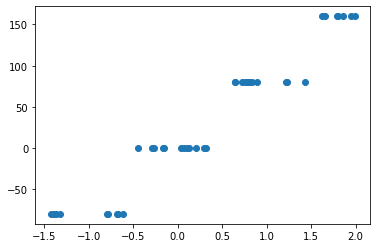

In [288]:
plt.scatter(train_df['x'], train_df['y'])
plt.show()

In [289]:
x = np.asarray(train_df['x']).reshape(-1, 1)
x_test = np.asarray(test_df['x']).reshape(-1, 1)

y = np.asarray(train_df['y']).reshape(-1, 1)

layers=[1, 128, 1]
weights, biases = generate_weights_and_biases(layers, -1, 1)

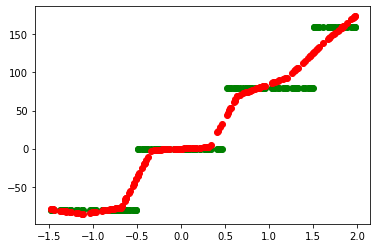

10.092777318104186


In [290]:
mlp = MLP(layers, weights, biases, output_function='linear', activation='relu', regularization_lambda=0)
        
mlp.train(x, y, epochs = 10000, batch_size=32, alpha=0.001)

predictions = mlp.forward(x_test)
plt.scatter(test_df['x'], test_df['y'], color='green')
plt.scatter(test_df['x'], predictions, color='red')
plt.show()
print(metrics.mean_absolute_error(test_df['y'], predictions))

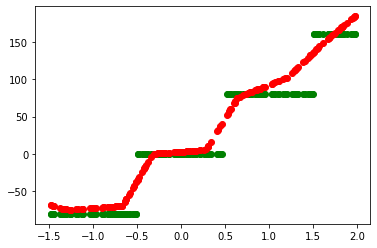

13.459786107107888


In [292]:
mlp= MLP(layers, weights, biases, output_function='linear', activation='relu', regularization_lambda=0.1)
mlp.train(x, y, epochs = 10000, batch_size=32, alpha=0.001)
predictions = mlp.forward(x_test)

plt.scatter(test_df['x'], test_df['y'], color='green')
plt.scatter(test_df['x'], predictions, color='red')
plt.show()

print(metrics.mean_absolute_error(test_df['y'], predictions))

## rings5-sparse

In [271]:
train_df = pd.read_csv('../data/rings5-sparse-training.csv', index_col=0).reset_index()
test_df = pd.read_csv('../data/rings5-sparse-test.csv', index_col=0).reset_index()

In [272]:
train_df

,x,y,c
0,25.269660,-16.259998,0
1,-89.688540,86.489735,0
2,-89.935929,95.105807,0
3,-74.534468,98.085259,0
4,33.597949,-15.746616,0
...,...,...,...
195,-99.913681,40.866932,4
196,-70.749497,71.324971,4
197,-52.830418,85.895679,4
198,67.671148,99.381210,4


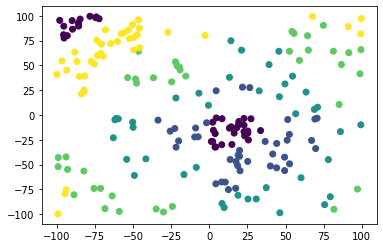

In [273]:
plt.scatter(train_df['x'], train_df['y'], c=train_df['c'])
plt.show()

In [274]:
x = np.asarray(train_df.iloc[:,0:2])
x = (x - np.mean(x, axis = 0))/np.std(x, axis = 0)

x_test = np.asarray(test_df.iloc[:,0:2])
x_test = (x_test - np.mean(x_test, axis = 0))/np.std(x_test, axis = 0)

y = np.asarray(train_df.iloc[:,2]).reshape(-1, 1)

layers=[2, 128, 128, 128, 5]
weights, biases = generate_weights_and_biases(layers, -1, 1)

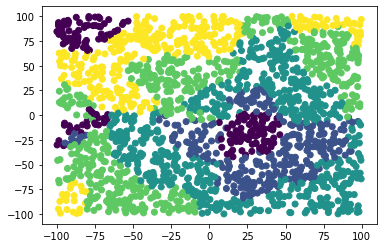

0.676


In [275]:
mlp = MLP(layers, weights, biases, output_function='softmax', activation='tanh' )
        
mlp.train(x, y, epochs = 500, batch_size=128, alpha=0.1)

predictions_b = mlp.forward(x_test)
result = np.argmax(predictions_b, axis = 1)

plt.scatter(test_df['x'], test_df['y'], c=result)
plt.show()

print(metrics.accuracy_score(test_df['c'], result ))

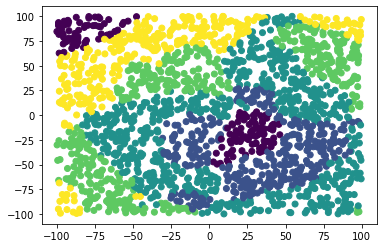

0.705


In [277]:
mlp2 = MLP(layers, weights, biases, output_function='softmax', activation='tanh' , regularization_lambda=0.01)
        
mlp2.train(x, y, epochs = 500, batch_size=128, alpha=0.1)

predictions_b = mlp2.forward(x_test)
result = np.argmax(predictions_b, axis = 1)

plt.scatter(test_df['x'], test_df['y'], c=result)
plt.show()

print(metrics.accuracy_score(test_df['c'], result ))

## rings3-balance 

In [278]:
train_df = pd.read_csv('../data/rings3-balance-training.csv', index_col=0).reset_index()
test_df = pd.read_csv('../data/rings3-balance-test.csv', index_col=0).reset_index()

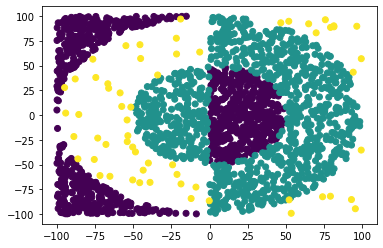

In [279]:
plt.scatter(train_df['x'], train_df['y'], c=train_df['c'])
plt.show()

In [280]:
x = np.asarray(train_df.iloc[:,0:2])
x = (x - np.mean(x, axis = 0))/np.std(x, axis = 0)

x_test = np.asarray(test_df.iloc[:,0:2])
x_test = (x_test - np.mean(x_test, axis = 0))/np.std(x_test, axis = 0)

y = np.asarray(train_df.iloc[:,2]).reshape(-1, 1)

layers=[2, 128, 128, 128, 3]
weights, biases = generate_weights_and_biases(layers, -1, 1)


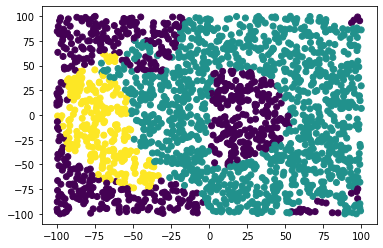

0.726


In [285]:
mlp = MLP(layers, weights, biases, output_function='softmax', activation='tanh' )
        
mlp.train(x, y, epochs = 50, batch_size=264, alpha=0.1)

predictions_b = mlp.forward(x_test)
result = np.argmax(predictions_b, axis = 1)

plt.scatter(test_df['x'], test_df['y'], c=result)
plt.show()

print(metrics.accuracy_score(test_df['c'], result ))

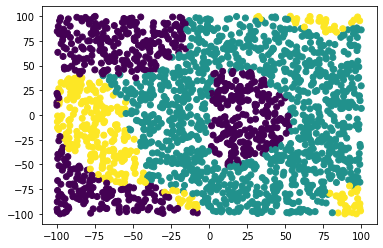

0.7445


In [283]:
mlp = MLP(layers, weights, biases, output_function='softmax', activation='tanh', regularization_lambda=0.1)
        
mlp.train(x, y, epochs = 50, batch_size=264, alpha=0.1)

predictions_b = mlp.forward(x_test)
result = np.argmax(predictions_b, axis = 1)

plt.scatter(test_df['x'], test_df['y'], c=result)
plt.show()

print(metrics.accuracy_score(test_df['c'], result ))

## xor3-balance 

In [293]:
train_df = pd.read_csv('../data/xor3-balance-training.csv', index_col=0).reset_index()
test_df = pd.read_csv('../data/xor3-balance-test.csv', index_col=0).reset_index()

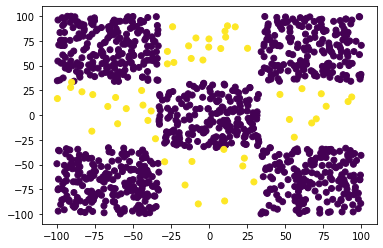

In [294]:
plt.scatter(train_df['x'], train_df['y'], c=train_df['c'])
plt.show()

In [297]:
x = np.asarray(train_df.iloc[:,0:2])
x = (x - np.mean(x, axis = 0))/np.std(x, axis = 0)

x_test = np.asarray(test_df.iloc[:,0:2])
x_test = (x_test - np.mean(x_test, axis = 0))/np.std(x_test, axis = 0)

y = np.asarray(train_df.iloc[:,2]).reshape(-1, 1)

layers=[2, 128, 128, 128, 2]
weights, biases = generate_weights_and_biases(layers, -1, 1)


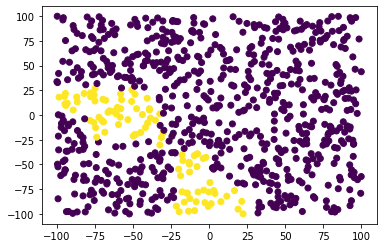

0.66125


In [303]:
mlp = MLP(layers, weights, biases, output_function='softmax', activation='tanh' )
        
mlp.train(x, y, epochs = 200, batch_size=264, alpha=0.1)

predictions_b = mlp.forward(x_test)
result = np.argmax(predictions_b, axis = 1)

plt.scatter(test_df['x'], test_df['y'], c=result)
plt.show()

print(metrics.accuracy_score(test_df['c'], result ))

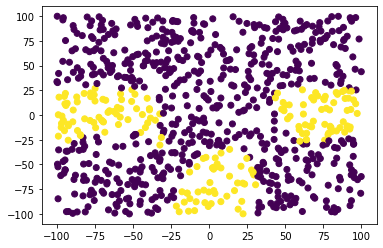

0.76875


In [304]:
mlp = MLP(layers, weights, biases, output_function='softmax', activation='tanh', regularization_lambda=0.1)
        
mlp.train(x, y, epochs = 200, batch_size=264, alpha=0.1)

predictions_b = mlp.forward(x_test)
result = np.argmax(predictions_b, axis = 1)

plt.scatter(test_df['x'], test_df['y'], c=result)
plt.show()

print(metrics.accuracy_score(test_df['c'], result ))

### Wnioski
Jak widać regularyzacja pomaga w klasyfikacji, w tych przypadkach nastąpiło polepszenie accuracy. W przypadku liniowym nastąpiło nieznaczne pogorszenie, podejrzewam że zbiór treningowy jest zbyt mało reprezentatywny

# Testowanie implementacji early stopping

## multimodal-sparse

In [476]:
train_df = pd.read_csv('../data/multimodal-sparse-training.csv', index_col=0)
test_df = pd.read_csv('../data/multimodal-sparse-test.csv', index_col=0)

p = np.random.permutation(len(test_df))
test_df = test_df.iloc[p,:]
val_df = test_df.iloc[0:(int(train_df.shape[0]*0.3)),:]
test_df = test_df.iloc[(int(train_df.shape[0]*0.3)):,:]

x = np.asarray(train_df['x']).reshape(-1, 1)
x_test = np.asarray(test_df['x']).reshape(-1, 1)
x_val = np.asarray(val_df['x']).reshape(-1, 1)

y = np.asarray(train_df['y']).reshape(-1, 1)
y_val = np.asarray(val_df['y']).reshape(-1, 1)

layers=[1, 128, 1]
weights, biases = generate_weights_and_biases(layers, -1, 1)

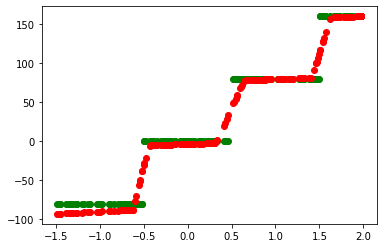

8.065195643262426


In [477]:
mlp = MLP(layers, weights, biases, output_function='linear', activation='relu')
        
mlp.train(x, y, epochs = 100000, batch_size=16, alpha=0.001)

predictions = mlp.forward(x_test)
plt.scatter(test_df['x'], test_df['y'], color='green')
plt.scatter(test_df['x'], predictions, color='red')
plt.show()
print(metrics.mean_absolute_error(test_df['y'], predictions))

Early stop activated! 25158 = 6.0158669817929335


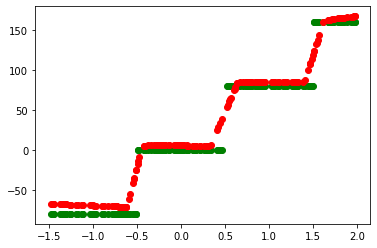

10.2239984153693


In [478]:
mlp = MLP(layers, weights, biases, output_function='linear', validation_set=(x_val, y_val),  early_stop=5000, activation='relu')
        
mlp.train(x, y, epochs = 100000, batch_size=16, alpha=0.001)

predictions = mlp.forward(x_test)
plt.scatter(test_df['x'], test_df['y'], color='green')
plt.scatter(test_df['x'], predictions, color='red')
plt.show()
print(metrics.mean_absolute_error(test_df['y'], predictions))

## rings5-sparse 

In [394]:
train_df = pd.read_csv('../data/rings5-sparse-training.csv', index_col=0).reset_index()
test_df = pd.read_csv('../data/rings5-sparse-test.csv', index_col=0).reset_index()

p = np.random.permutation(len(test_df))
test_df = test_df.iloc[p,:]
val_df = test_df.iloc[0:(int(train_df.shape[0]*0.2)),:]
test_df = test_df.iloc[(int(train_df.shape[0]*0.2)):,:]

x = np.asarray(train_df.iloc[:,0:2])
x = (x - np.mean(x, axis = 0))/np.std(x, axis = 0)

x_val = np.asarray(val_df.iloc[:,0:2])
x_val = (x_val - np.mean(x_val, axis = 0))/np.std(x_val, axis = 0)
y_val = np.asarray(val_df.iloc[:,2]).reshape(-1, 1)

x_test = np.asarray(test_df.iloc[:,0:2])
x_test = (x_test - np.mean(x_test, axis = 0))/np.std(x_test, axis = 0)

y = np.asarray(train_df.iloc[:,2]).reshape(-1, 1)

layers=[2, 128, 128, 128, 5]
weights, biases = generate_weights_and_biases(layers, -1, 1)

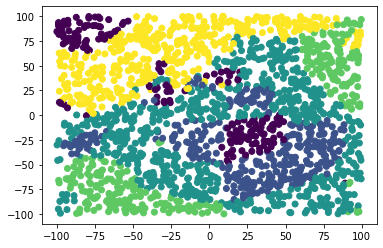

0.6173469387755102


In [404]:
mlp = MLP(layers, weights, biases, output_function='softmax', activation='tanh')
        
mlp.train(x, y, epochs = 1000, batch_size=264, alpha=0.1)

predictions_b = mlp.forward(x_test)
result = np.argmax(predictions_b, axis = 1)

plt.scatter(test_df['x'], test_df['y'], c=result)
plt.show()

print(metrics.accuracy_score(test_df['c'], result ))

Early stop activated! epoch 359 = 0.7821757108158465


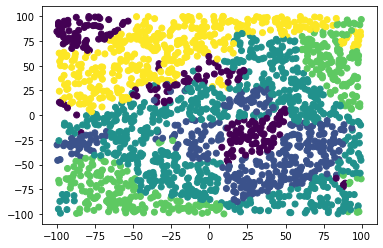

0.6035714285714285


In [405]:
mlp = MLP(layers, weights, biases, output_function='softmax', activation='tanh', validation_set=(x_val, y_val), early_stop = 100)
        
mlp.train(x, y, epochs = 1000, batch_size=264, alpha=0.1)

predictions_b = mlp.forward(x_test)
result = np.argmax(predictions_b, axis = 1)

plt.scatter(test_df['x'], test_df['y'], c=result)
plt.show()

print(metrics.accuracy_score(test_df['c'], result ))

## rings3-balance

In [408]:
train_df = pd.read_csv('../data/rings3-balance-training.csv', index_col=0).reset_index()
test_df = pd.read_csv('../data/rings3-balance-test.csv', index_col=0).reset_index()

p = np.random.permutation(len(test_df))
test_df = test_df.iloc[p,:]
val_df = test_df.iloc[0:(int(train_df.shape[0]*0.2)),:]
test_df = test_df.iloc[(int(train_df.shape[0]*0.2)):,:]

x = np.asarray(train_df.iloc[:,0:2])
x = (x - np.mean(x, axis = 0))/np.std(x, axis = 0)

x_val = np.asarray(val_df.iloc[:,0:2])
x_val = (x_val - np.mean(x_val, axis = 0))/np.std(x_val, axis = 0)
y_val = np.asarray(val_df.iloc[:,2]).reshape(-1, 1)

x_test = np.asarray(test_df.iloc[:,0:2])
x_test = (x_test - np.mean(x_test, axis = 0))/np.std(x_test, axis = 0)

y = np.asarray(train_df.iloc[:,2]).reshape(-1, 1)

layers=[2, 128, 128, 128, 3]
weights, biases = generate_weights_and_biases(layers, -1, 1)

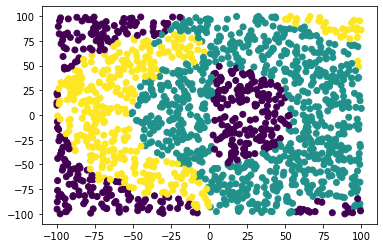

0.8243073047858942


In [411]:
mlp = MLP(layers, weights, biases, output_function='softmax', activation='tanh')
        
mlp.train(x, y, epochs = 300, batch_size=264, alpha=0.1)

predictions_b = mlp.forward(x_test)
result = np.argmax(predictions_b, axis = 1)

plt.scatter(test_df['x'], test_df['y'], c=result)
plt.show()

print(metrics.accuracy_score(test_df['c'], result ))

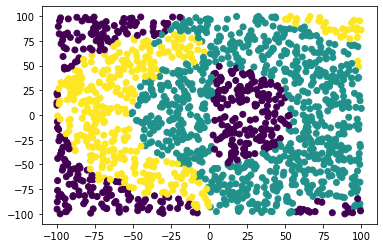

0.8243073047858942


In [412]:
mlp = MLP(layers, weights, biases, output_function='softmax', activation='tanh', validation_set=(x_val, y_val), early_stop = 50)
        
mlp.train(x, y, epochs = 300, batch_size=264, alpha=0.1)

predictions_b = mlp.forward(x_test)
result = np.argmax(predictions_b, axis = 1)

plt.scatter(test_df['x'], test_df['y'], c=result)
plt.show()

print(metrics.accuracy_score(test_df['c'], result ))

## xor3-balance

In [424]:
train_df = pd.read_csv('../data/xor3-balance-training.csv', index_col=0).reset_index()
test_df = pd.read_csv('../data/xor3-balance-test.csv', index_col=0).reset_index()

val_df = test_df.iloc[0:(int(train_df.shape[0]*0.3)),:]
test_df = test_df.iloc[(int(train_df.shape[0]*0.3)):,:]

x = np.asarray(train_df.iloc[:,0:2])
x = (x - np.mean(x, axis = 0))/np.std(x, axis = 0)

x_val = np.asarray(val_df.iloc[:,0:2])
x_val = (x_val - np.mean(x_val, axis = 0))/np.std(x_val, axis = 0)
y_val = np.asarray(val_df.iloc[:,2]).reshape(-1, 1)

x_test = np.asarray(test_df.iloc[:,0:2])
x_test = (x_test - np.mean(x_test, axis = 0))/np.std(x_test, axis = 0)

y = np.asarray(train_df.iloc[:,2]).reshape(-1, 1)

layers=[2, 128, 128, 128, 2]
weights, biases = generate_weights_and_biases(layers, -1, 1)


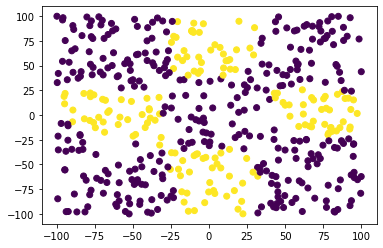

0.8536082474226804


In [437]:
mlp = MLP(layers, weights, biases, output_function='softmax', activation='tanh')
        
mlp.train(x, y, epochs = 2000, batch_size=128, alpha=0.1)

predictions_b = mlp.forward(x_test)
result = np.argmax(predictions_b, axis = 1)

plt.scatter(test_df['x'], test_df['y'], c=result)
plt.show()

print(metrics.accuracy_score(test_df['c'], result ))

Early stop activated! epoch 951 = 0.0037303768605152428


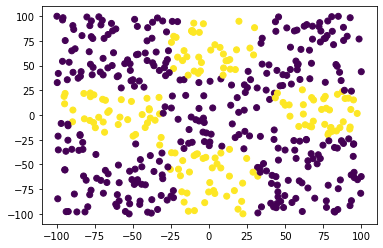

0.8494845360824742


In [438]:
mlp = MLP(layers, weights, biases, output_function='softmax', activation='tanh', validation_set=(x_val, y_val), early_stop = 69)
        
mlp.train(x, y, epochs = 2000, batch_size=128, alpha=0.1)

predictions_b = mlp.forward(x_test)
result = np.argmax(predictions_b, axis = 1)

plt.scatter(test_df['x'], test_df['y'], c=result)
plt.show()

print(metrics.accuracy_score(test_df['c'], result ))

## Wnioski

W powyższych przypadkach early stopping niekoniecznie sprawił aby sieci się nie przeuczały. Może wynikać to z prostoty tych funkcji - rozkłady zbiorów testowych i treningowych nie różniły wystarczająco by early stopping osiągnął swój potencjał. 